In [212]:
#VERSION INFO
import sys
import sklearn
import tensorflow
import keras
import platform

print (sys.version)
print("Python Version",  platform.python_version())
print ("Tensorflow Version:", tensorflow.__version__)
print ("sklearn Version",sklearn.__version__)
print ("Keras Version",keras.__version__)

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Python Version 3.7.4
Tensorflow Version: 2.1.0
sklearn Version 0.21.3
Keras Version 2.3.1


In [213]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7948239989922498184
]


In [214]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
import csv

In [215]:
#Misc
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re

#Sci-kit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

In [216]:
path = r'C:\Users\Mukuu\Desktop\MSc Proj'
data = pd.read_table(path + r'\OLID\olid-training-v1.0.tsv')
test_df = pd.read_csv(path + r'\test_b_tweets_cleaned.csv')
print(data.head())

      id                                              tweet subtask_a  \
0  86426  @USER She should ask a few native Americans wh...       OFF   
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...       OFF   
2  16820  Amazon is investigating Chinese employees who ...       NOT   
3  62688  @USER Someone should'veTaken" this piece of sh...       OFF   
4  43605  @USER @USER Obama wanted liberals &amp; illega...       NOT   

  subtask_b subtask_c  
0       UNT       NaN  
1       TIN       IND  
2       NaN       NaN  
3       UNT       NaN  
4       NaN       NaN  


In [217]:
def clean_text(sentence):
    trans = str.maketrans('','', string.punctuation)
    emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)
    stop_words = set(stopwords.words('english'))
    for i in range(len(sentence)):
        sentence[i] = sentence[i].lower()                # To lower case
        sentence[i] = re.sub(r'\d+', '', sentence[i])    # Remove numbers
        sentence[i] = re.sub(r'’',r"'",sentence[i])     # Modify astrophies
        sentence[i] = re.sub(r'”',r"'",sentence[i])
        sentence[i] = re.sub('@user', '', sentence[i])   # Remove @user
        sentence[i] = sentence[i].translate(trans)       # Remove punctuations
        sentence[i] = emoji_pattern.sub(r'', sentence[i])# Remove imojis
        #sentence[i] = sentence[i].strip()                # Remove white space
        tokens = word_tokenize(sentence[i])
        #print(tokens)
        result = [i for i in tokens if not i in stop_words]
        #print(result)
        sentence[i] = result
    return sentence
# Concatenating everything
def Concat(list_tokens):
    result = []
    for i in list_tokens:
        temp = ''
        for j in i:
            temp = temp + j + ' '
        #print(temp)
        result.append(temp[:-1])
    return result

In [218]:
data = data[['tweet','subtask_b']]

#Filtering data
te = []
la = []
print(len(data))
for i in range(len(data)):
    #print(data['subtask_b'][i])
    if data['subtask_b'][i] == 'TIN' or data['subtask_b'][i] == 'UNT':
        te.append(data['tweet'][i])
        la.append(data['subtask_b'][i])
temp = {'tweet' : te,
        'subtask_b' : la}
data = pd.DataFrame(temp, columns = ['tweet','subtask_b'])
# data

13240


In [219]:
#PREPROCESSING CELL

#REMOVING OTHER SUBTASKS
# data = data[['tweet','subtask_a']]

#FACTORIZING LABELS
data['label']=data['subtask_b'].factorize()[0]
data = data[['tweet','label']]

sentence = []
for i in data['tweet']:
    sentence.append(i)
clean_tokens = clean_text(sentence)
clean_sentences = Concat(clean_tokens)
cleaned = {'tweet' : clean_sentences,
           'label' : data['label']}
data = pd.DataFrame(cleaned, columns = ['tweet','label'])

print(data.head())

count0 = 0
count1 = 0
for i in data["label"]:
    if i == 0:
        count0+=1
    else:
        count1+=1
print("Offensive Tweets: ",count0)
print("Non Offensive Tweets: ",count1)

                                      tweet  label
0                 ask native americans take      0
1        go home youre drunk maga trump url      1
2  someone shouldvetaken piece shit volcano      0
3                           liberals kookoo      1
4                        oh noes tough shit      0
Offensive Tweets:  524
Non Offensive Tweets:  3876


In [220]:
#TOKENIZING AND CREATING SEQUENCE 1
vocabulary_size = 30000
max_len = 100
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(data['tweet'])

sequences = tokenizer.texts_to_sequences(data['tweet'])
X = pad_sequences(sequences, maxlen=max_len)
print(X.shape)
y = np.array(data['label'])

(4400, 100)


In [221]:
test_df
test = {'tweet':test_df['text'],
        'label':test_df['label'].factorize()[0]
}
test = pd.DataFrame(test,columns = ['tweet','label'])
print(test.head())
count0 = 0
count1 = 0
for i in test["label"]:
    if i == 0:
        count0+=1
    else:
        count1+=1
print("Offensive Tweets: ",count0)
print("Non Offensive Tweets: ",count1)

                                               tweet  label
0  top completely fuck trainer boyfriend went fuc...      0
1  course many slovenes respond along lines fool ...      1
2                      means go away sorry ass kkkkk      1
3   hes closer trumps ass greatly shortens kiss time      1
4  looking back old photos makes physically sick ...      0
Offensive Tweets:  572
Non Offensive Tweets:  850


In [222]:
#TOKENIZING AND CREATING SEQUENCE 2
vocabulary_size = 30000
max_len = 100
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(test['tweet'])
sequences = tokenizer.texts_to_sequences(test['tweet'])
X_test = pad_sequences(sequences, maxlen=max_len)
print(X_test.shape)
y_test = np.array(test['label'])

(1422, 100)


In [223]:
#GLOBAL VARIABLES
EMBEDDING_DIM = 200
class_weight = {0:1,1:1}
epochs = 10
split = 0.2

In [224]:
#GLOVE WORD EMBEDDINGS
embeddings_index = dict()
f = open('glove.twitter.27B/glove.twitter.27B.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocabulary_size, 200))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
print("Embeddings Weight Calculated")

Embeddings Weight Calculated


In [225]:
#CROSS VALIDATION 

X_train, X_test, y_train, y_test = X, X_test, y, y_test

In [226]:
from keras.layers import Bidirectional

In [227]:

#MODEL ARCHITECTURE 2
print("Fitting The model")
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 200, input_length=max_len, weights=[embedding_matrix], trainable=False))
model_glove.add(Bidirectional(LSTM(200,return_sequences = True)))
model_glove.add(Bidirectional(LSTM(50)))
model_glove.add(Dense(2, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate = 0.0005)
model_glove.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Fit train data
hist = model_glove.fit(X_train,
                       y_train,
                       validation_split = split,
                       epochs = epochs,
                       class_weight = class_weight)

Fitting The model
Train on 3520 samples, validate on 880 samples
Epoch 1/10
3520/3520 [==============================] - 85s 24ms/step - loss: 0.3740 - accuracy: 0.8730 - val_loss: 0.3586 - val_accuracy: 0.8830
Epoch 2/10
3520/3520 [==============================] - 82s 23ms/step - loss: 0.3486 - accuracy: 0.8810 - val_loss: 0.3588 - val_accuracy: 0.8841
Epoch 3/10
3520/3520 [==============================] - 81s 23ms/step - loss: 0.3338 - accuracy: 0.8824 - val_loss: 0.3695 - val_accuracy: 0.8739
Epoch 4/10
3520/3520 [==============================] - 79s 22ms/step - loss: 0.3155 - accuracy: 0.8889 - val_loss: 0.3828 - val_accuracy: 0.8716
Epoch 5/10
3520/3520 [==============================] - 79s 22ms/step - loss: 0.2973 - accuracy: 0.8869 - val_loss: 0.3961 - val_accuracy: 0.8773
Epoch 6/10
3520/3520 [==============================] - 79s 22ms/step - loss: 0.2672 - accuracy: 0.8949 - val_loss: 0.4385 - val_accuracy: 0.8557
Epoch 7/10
3520/3520 [==============================] - 79s

In [228]:
#EVALUATE THE MODEL
print('123')
from sklearn.metrics import classification_report 
score = model_glove.evaluate(X_test,y_test,batch_size=32,verbose=1)
y_pred = model_glove.predict_classes(X_test, batch_size=32, verbose=0)
conf_mat = confusion_matrix(y_test, y_pred)

#DISPLAYING SCORES
print("Confusion Matrix:")
print(conf_mat)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

print("\nClassification Report: ")
target_names = ["Class {}".format(i) for i in range(2)]
print(classification_report(y_test, y_pred, 
                            target_names=target_names, 
                            digits = 4))
accuracy_sklearn = accuracy_score(y_test, y_pred, 
                                  normalize=True,
                                  sample_weight=None)
print("Sklearn Accuracy: ",accuracy_sklearn)

123
1422/1422 [==============================] - 4s 3ms/step
Confusion Matrix:
[[ 32 540]
 [ 54 796]]
Test Loss: 2.2188845447011807
Test Accuracy: 0.5822784900665283

Classification Report: 
              precision    recall  f1-score   support

     Class 0     0.3721    0.0559    0.0973       572
     Class 1     0.5958    0.9365    0.7283       850

    accuracy                         0.5823      1422
   macro avg     0.4840    0.4962    0.4128      1422
weighted avg     0.5058    0.5823    0.4744      1422

Sklearn Accuracy:  0.5822784810126582


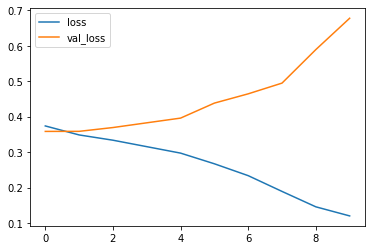

In [229]:
#PLOTS
import matplotlib.pyplot as plt

# plot some data
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

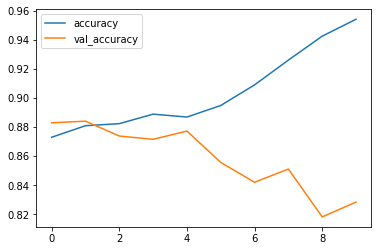

In [230]:
#ACCURACIES
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [231]:
model_glove.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 200)          6000000   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 100, 400)          641600    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 100)               180400    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 202       
Total params: 6,822,202
Trainable params: 822,202
Non-trainable params: 6,000,000
_________________________________________________________________
